# FT_SOMMELIER

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
red_wine_df = pd.read_csv("resources/winequality-red.csv", sep=';')
white_wine_df = pd.read_csv("resources/winequality-white.csv", sep=';')

In [3]:
print(len(red_wine_df))
red_wine_df.head()

1599


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
white_wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### V.1 Exploring the green reds

#### a) Plot scatter matrix function

In [ ]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False, name=None):
    fig, axmat = plt.subplots(12, 12, figsize=(20, 20))
    for axrow in axmat:
        for ax in axrow:
            ax.set_xticks([])
            ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    h_list = wine_data.columns.values
    for i in range(len(h_list)):
        for j in range(len(h_list)):
            plt.sca(axmat[i][j])
            if (i == j):
                plt.text(0.5, 0.5, h_list[j].replace(' ', '\n'), fontsize=16, ha='center', va='center')
            else:
                plt.scatter(wine_data[h_list[j]][wine_data['quality'] > good_threshold],
                            wine_data[h_list[i]][wine_data['quality'] > good_threshold], s=3, c='g')
                plt.scatter(wine_data[h_list[j]][wine_data['quality'] < bad_threshold],
                            wine_data[h_list[i]][wine_data['quality'] < bad_threshold], s=3, c='m')
    if (save_plot):
        if (name == None):
            plt.savefig('Plt.png') # bbox_inches='tight' to remove white space around
        else:
            plt.savefig("{}.png".format(name))
    plt.show()

In [ ]:
plot_scatter_matrix(red_wine_df, 7, 4)

#### b) Which factors do you think will be most useful for distinguishing high vs low quality wines

At a first glance I see that sulphates and alcohol have a clearer division when it comes to quality.
We can see in the figure that in most cases a higher alcohol quantity and a higher level of sulphates results
in a beter quality wine. This is the case when comparing high quality wines (8 or higher) vs low quality wines
(3 or lower)

### V.2 Learning to perceptron

#### a) & b) Perceptron implementation and training

In [8]:
def heaviside_step_fn(nb):
    if (nb < 0):
        return (0)
    elif (nb >= 0):
        return (1)

def dot_prod(v1, v2):
    return (sum([x * y for x, y in zip(v1, v2)]))

def vec_add(v1, v2):
    return ([round(x + y, 2) for x, y in zip(v1, v2)])
    
def vec_sub(v1, v2):
    return ([round(x - y, 2) for x, y in zip(v1, v2)])

def vec_scale(v, scalar):
    return ([i * scalar for i in v])

def select_features_labels(wine_data, good_quality_nb, bad_quality_nb):
    tmp = wine_data[['pH', 'alcohol', 'quality']][(
        wine_data['quality'] > good_quality_nb) | (wine_data['quality'] < bad_quality_nb)]
    tmp['quality'].where(tmp['quality'] < bad_quality_nb, 1, inplace=True) # Replace good_quality_nb and above with 1
    tmp['quality'].where(tmp['quality'] == 1, 0, inplace=True) # and bad quality and below with 0
    features = tmp[['pH', 'alcohol']]
    labels = tmp[['quality']]
    features = [list(features[item]) for item in features]
    labels = [list(labels[item]) for item in labels]
    labels = labels[0]
    return (features, labels) # returns a list of lists containing the values of each feature

def update_weights(w, x, y, l_rate):
    update = False
    if (heaviside_step_fn(dot_prod(w, x)) == 1 and y == 0):
        update = True
        w = vec_sub(w, vec_scale(x, l_rate)) # w = w - lr * x
    elif (heaviside_step_fn(dot_prod(w, x)) == 0 and y == 1):
        update = True
        w = vec_add(w, vec_scale(x, l_rate)) # w = w + lr * x
    return (w, update)
    
def perceptron_trainer(wine_data, l_rate, epochs):
    features, labels = select_features_labels(wine_data, 7, 4)
    train_until_convergence = False
    epoch_count = 0
    info = []
    if (epochs == 0):
        train_until_convergence = True # train until convergence if epochs is 0
        epochs = 1 # epoch_count < epochs so it enters the loop
    converged = False
    w = [0, 0, 0] # w[0] is the bias
    for i in range(3):
        w[i] = round(random.uniform(-1, 1), 2) # init random weights between -1 and 1
    while (not converged and epoch_count < epochs):
        converged = True
        errors_at_epoch = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            w, update = update_weights(w, x, y, l_rate)
            if (update == True): # if there was no update in the whole dataset that means our model has converged
                converged = False
                errors_at_epoch += 1
        info.append((epoch_count, errors_at_epoch, w))
        epoch_count += 1
        if (train_until_convergence == True):
            epochs = epoch_count + 1 # we don't want to stop training until convergence
    return (info)

In [9]:
random.seed(1998)
performance = perceptron_trainer(red_wine_df, l_rate=0.98, epochs=0)

#### c) Plot perceptron performance

In [10]:
def plot_perceptron_performance(wine_data, performance, good_threshold, bad_threshold, epoch=-1):
    fig, axvec = plt.subplots(1, 2, figsize=(15, 5))
    if (epoch >= 0):
        performance = performance[: epoch + 1]
    else:
        epoch = performance[-1][0]
    df = pd.DataFrame(performance)
    
    plt.sca(axvec[0])
    plt.plot(df[0], df[1])
    plt.xlabel('epoch')
    plt.ylabel('classification errors')
    plt.title('Error as a function of epoch')
    
    plt.sca(axvec[1])
    good = plt.scatter(wine_data['pH'][wine_data['quality'] > good_threshold],
                wine_data['alcohol'][wine_data['quality'] > good_threshold], s=15, c='g')
    bad = plt.scatter(wine_data['pH'][wine_data['quality'] < bad_threshold],
                wine_data['alcohol'][wine_data['quality'] < bad_threshold], s=15, c='m')
    plt.legend((good, bad), ('good wines (> {} score)'.format(good_threshold),
                             'bad wines (< {} score)'.format(bad_threshold)), loc=(1.01, 0.88))
    plt.xlabel('pH')
    plt.ylabel('alcohol')
    plt.title('Decision boundary on epoch {}'.format(epoch))
    x_list = [2.8, 3.8]
    w = performance[-1][2]
    #w[0] /= 250
    #w[1] /= 250
    #w[2] /= 250
    print(w)
    x_intercept = -w[0] / w[1]
    y_intercept = -w[0] / w[2]
    # m = (y2 - y1) / (x2 - x1)
    m = -y_intercept / x_intercept
    # y = mx + b
    y = [0, 0]
    y[0] = m * x_list[0] + w[0]
    y[1] = m * x_list[1] + w[0]
    #y = (-1 * w[1] / w[2]) * x_list + (-1 * w[0] / w[2]) # this is just math. source: https://medium.com/@thomascountz/calculate-the-decision-boundary-of-a-single-perceptron-visualizing-linear-separability-c4d77099ef38
    #plt.plot(x_list, y)
    
    plt.show()

[478.42, -646.82, 161.1]


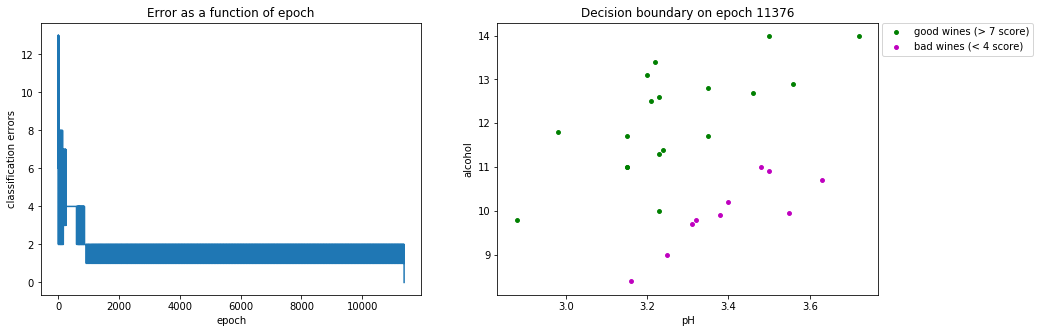

In [11]:
plot_perceptron_performance(red_wine_df, performance, 7, 4)

#### d) Feature scaling for faster training

In [12]:
def normalize_data(wine_data):
    quality = wine_data["quality"]
    norm_wine_data = wine_data.drop(labels="quality", axis='columns')
    norm_wine_data = (norm_wine_data - norm_wine_data.mean()) / (norm_wine_data.max() - norm_wine_data.min())
    norm_wine_data["quality"] = quality
    return (norm_wine_data)

[0.18, -4.24, 4.29]


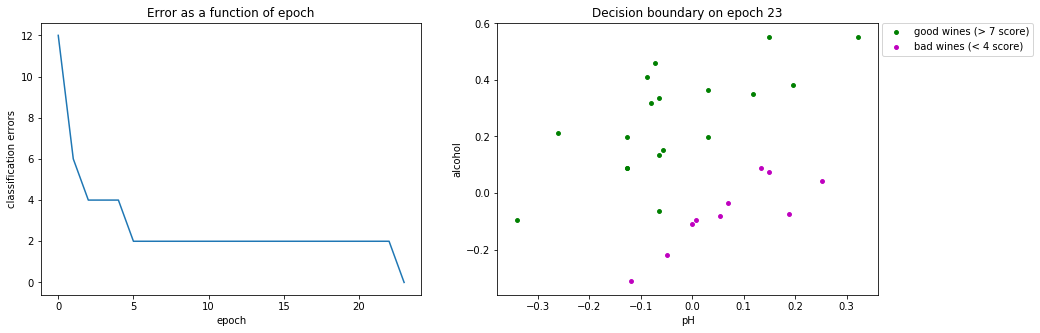

In [13]:
random.seed(1998)
norm_red_wine_df = normalize_data(red_wine_df)
norm_perf = perceptron_trainer(norm_red_wine_df, l_rate=0.98, epochs=0)
plot_perceptron_performance(norm_red_wine_df, norm_perf, 7, 4)

### V.3 My fair ADALINE

#### a)&b)&c) Implement an ADALINE with gradient descent and a training function

In [56]:
class Adaline:
    def __init__(self):
        self.weights = [0, 0, 0]
        for i in range(3):
            self.weights[i] = round(random.uniform(-1, 1), 2) # w[0] is the bias
    def weight_update(self, x, y, l_rate, error):
        #error = y - dot_prod(self.weights, x)
        w_update = vec_scale(v=x, scalar=2 * l_rate * error)
        self.weights = vec_add(self.weights, w_update) # update weights
    def test(self, features, labels):
        error_count = 0
        for x1, x2, y in zip(features[0], features[1], labels):
            x = [1, x1, x2]
            if (dot_prod(self.weights, x) >= 0.5):
                output = 1
            else:
                output = 0
            if (y != output):
                error_count += 1
        return (error_count)
    def next_batch(self, features, labels, batch_size):
        for i in range(0, len(labels), batch_size):
            yield features[:][i:i + batch_size], labels[i:i + batch_size]
    def train(self, wine_data, l_rate, batch_size=1, epochs=0, good_nb=6, bad_nb=5):
        features, labels = select_features_labels(wine_data, good_nb, bad_nb)
        train_until_convergence = False
        epoch_count = 0
        info = []
        if (epochs == 0):
            train_until_convergence = True # train until convergence if epochs is 0
            epochs = 1 # epoch_count < epochs so it enters the loop
        converged = False
        errors_at_prev_epoch = self.test(features, labels)
        count = 0
        info.append((epoch_count, errors_at_prev_epoch, self.weights))
        while (not converged and epoch_count < epochs):
            converged = True
            generator = self.next_batch(features, labels, batch_size)
            for batch_x, batch_y in generator:
                batch_loss = 0
                for x1, x2, y in zip(features[0], features[1], labels):
                    x = [1, x1, x2]
                    self.weight_update(x, y, l_rate)
                errors_at_epoch = self.test(features, labels)
                if (errors_at_epoch > 0):
                    if (errors_at_epoch >= errors_at_prev_epoch):
                        count += 1
                    else:
                        count = 0
                    if (count < 1000):
                        converged = False
                errors_at_prev_epoch = errors_at_epoch
                epoch_count += 1
                info.append((epoch_count, errors_at_epoch, self.weights))
                if (train_until_convergence == True):
                    epochs = epoch_count + 1
        return (info)

In [59]:
features, labels = select_features_labels(red_wine_df, 6, 5)

In [84]:
def next_batch(features, labels, batch_size):
    for i in range(0, len(labels), batch_size):
        yield features[0][i:i + batch_size], features[1][i:i + batch_size], labels[i:i + batch_size]

In [85]:
generator = next_batch(features, labels, 5)

In [86]:
x1, x2, y = next(generator)

In [87]:
x1

[3.39, 3.36, 3.3, 3.38, 3.23]

In [88]:
x2

[10.0, 9.5, 10.5, 9.0, 9.7]

In [89]:
y

[1, 1, 1, 0, 1]

In [75]:
features[:][0]

[3.39,
 3.36,
 3.3,
 3.38,
 3.23,
 3.5,
 3.26,
 3.9,
 3.38,
 3.31,
 3.16,
 3.75,
 3.42,
 2.74,
 3.17,
 3.37,
 3.36,
 3.57,
 3.51,
 3.22,
 3.2,
 3.2,
 3.31,
 3.31,
 3.54,
 3.07,
 3.07,
 3.36,
 3.35,
 3.2,
 3.6,
 3.35,
 3.23,
 3.38,
 3.25,
 3.38,
 3.34,
 3.34,
 3.37,
 3.37,
 3.05,
 3.34,
 3.17,
 3.11,
 3.58,
 3.24,
 3.15,
 3.07,
 3.07,
 3.2,
 3.01,
 3.2,
 3.19,
 3.56,
 3.22,
 3.18,
 3.05,
 3.27,
 3.28,
 3.52,
 3.15,
 3.52,
 3.15,
 2.88,
 2.95,
 3.23,
 3.57,
 3.26,
 3.22,
 3.26,
 3.25,
 3.15,
 3.32,
 3.34,
 3.32,
 3.15,
 3.15,
 3.17,
 3.17,
 3.18,
 3.21,
 3.16,
 3.25,
 3.04,
 3.09,
 3.09,
 3.16,
 3.2,
 3.3,
 3.34,
 2.98,
 3.3,
 3.12,
 3.72,
 3.05,
 3.26,
 3.34,
 3.43,
 3.35,
 3.37,
 3.32,
 3.33,
 2.92,
 3.41,
 3.63,
 3.32,
 3.29,
 3.54,
 3.24,
 3.56,
 3.33,
 3.27,
 3.33,
 3.44,
 3.71,
 3.4,
 3.46,
 3.38,
 3.38,
 3.38,
 3.26,
 3.26,
 3.24,
 3.24,
 3.51,
 3.4,
 3.15,
 3.43,
 3.23,
 3.12,
 3.31,
 3.4,
 3.15,
 3.31,
 3.31,
 3.48,
 3.58,
 3.58,
 3.41,
 3.41,
 3.27,
 3.47,
 3.2,
 3.3,
 3.07,
 3

In [74]:
next(generator[0])

TypeError: 'generator' object is not subscriptable

#### d) Finding good hyperparameters for my ADALINE

[nan, nan, nan]


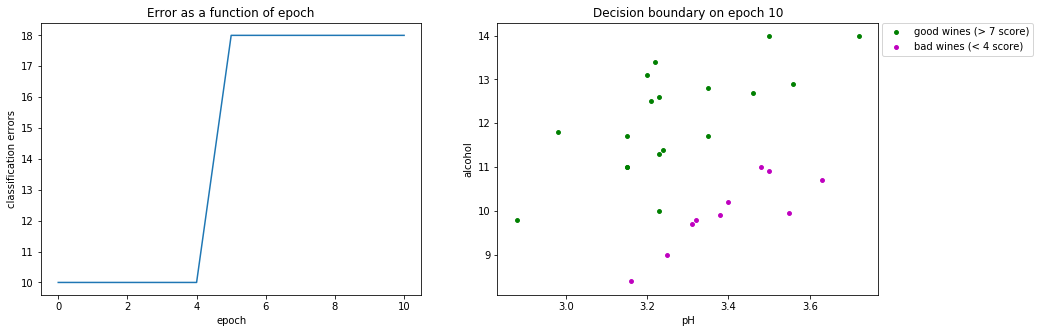

In [25]:
random.seed(1998)
good_threshold = 7
bad_threshold = 4
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.3, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

[nan, nan, nan]


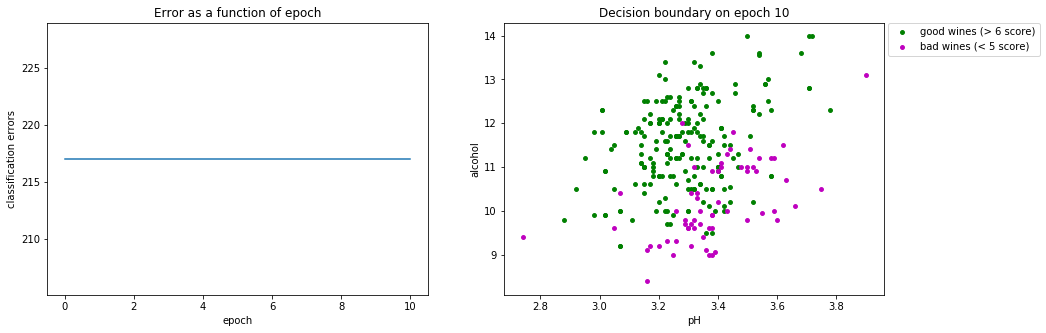

In [28]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.3, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

[nan, nan, nan]


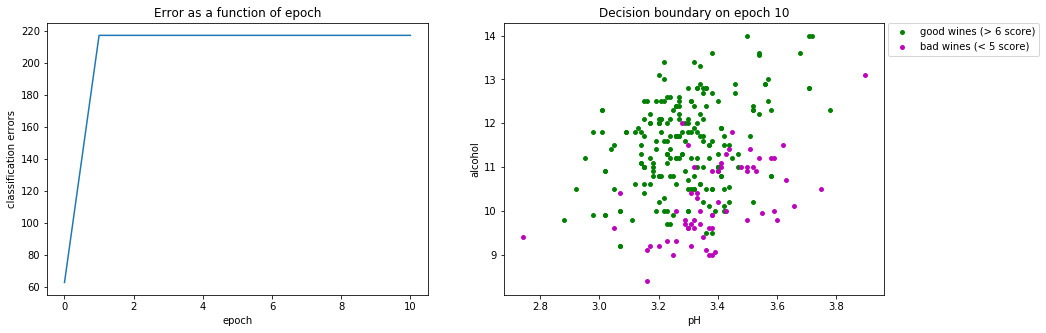

In [29]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.03, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

[0.18, -0.76, 0.26]


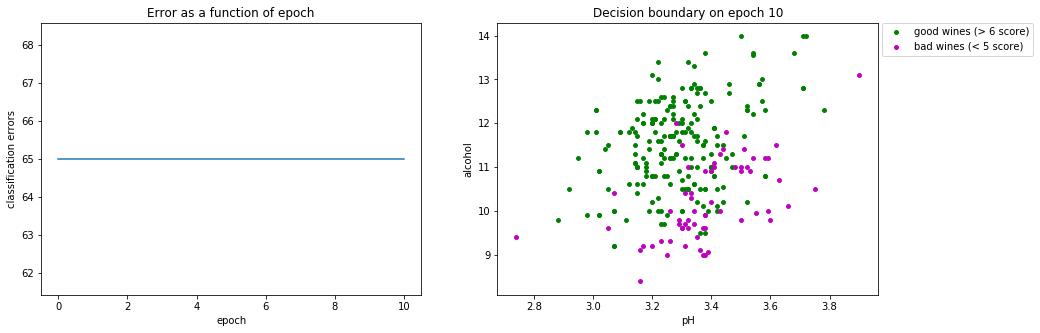

In [30]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.0003, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)

[0.18, -0.75, 0.3]


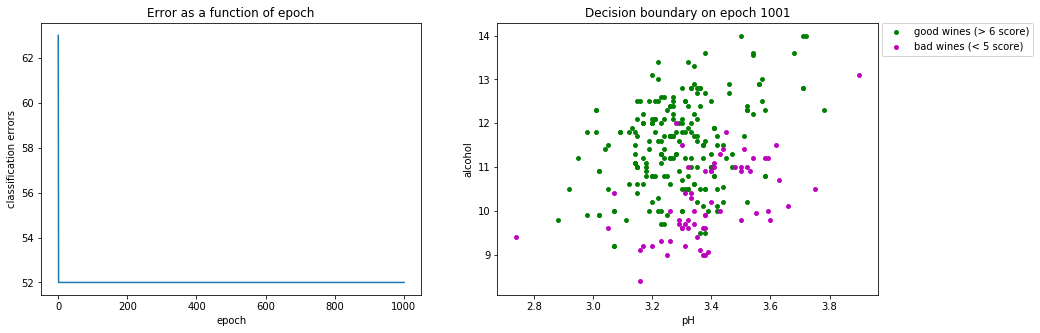

In [58]:
random.seed(1998)
good_threshold = 6
bad_threshold = 5
my_adaline = Adaline()
perf = my_adaline.train(red_wine_df, l_rate=0.002, good_nb=good_threshold, bad_nb=bad_threshold)
plot_perceptron_performance(red_wine_df, perf, good_threshold, bad_threshold)